In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with = engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
Base.metadata.create_all(engine)

# Exploratory Precipitation Analysis

In [14]:
inspector = inspect(engine)
columns_measurement = inspector.get_columns('station')
columns_measurement

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'name',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'latitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'longitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'elevation',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [15]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

most_recent_date

('2017-08-23',)

In [36]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

from datetime import timedelta
most_recent_date = dt.date(2017, 8, 23)
start_date = most_recent_date - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores

precip_scores = session.query(measurement.date, measurement.prcp).filter(measurement.date >= start_date, measurement.date <= most_recent_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_scores_data = []
for scores in precip_scores:
    precip_scores_data.append({'Date': scores.date, 'Precipitation': scores.prcp})
precip_scores_df = pd.DataFrame(precip_scores, columns = ['Date', 'Precipitation'])

# Sort the dataframe by date
precip_scores_df = precip_scores_df.sort_values(by = 'Date').fillna(0.0)
precip_scores_df['Date'] = pd.to_datetime(precip_scores_df['Date'])
precip_scores_df.set_index('Date', inplace = True)
precip_scores_df

# Use Pandas Plotting with Matplotlib to plot the data


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


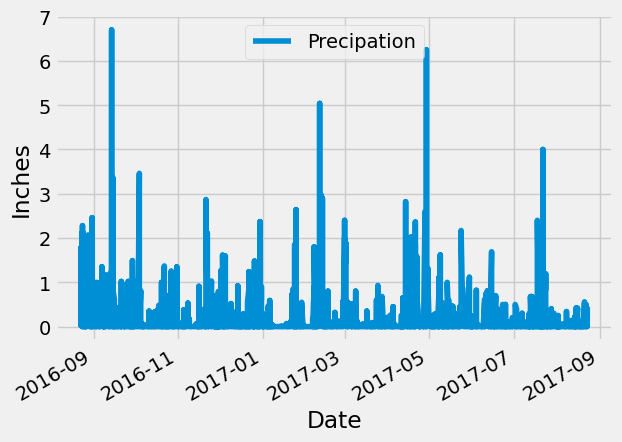

In [32]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = precip_scores_df.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Inches')
plt.show()

In [37]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precip_scores_df['Precipitation'].describe()
summary_stats

count    2230.000000
mean        0.160664
std         0.442067
min         0.000000
25%         0.000000
50%         0.010000
75%         0.110000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [45]:
# Design a query to calculate the total number of stations in the dataset
station_count = engine.execute('select count(station) from station').fetchall()
print(station_count)

[(9,)]


In [48]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
print(most_active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [54]:
select = engine.execute('select * from station where id = 7').fetchall()
print(select)

[(7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)]


In [57]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_stations_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
filter(measurement.station == 'USC00519281').first()
print(most_active_stations_stats)

(54.0, 85.0, 71.66378066378067)


In [66]:
MAS_id_temps = session.query(measurement.date, measurement.tobs).filter(measurement.station == 'USC00519281', \
                                                                       measurement.date >= start_date, \
                                                                       measurement.date <= most_recent_date).all()
MAS_id_df = pd.DataFrame(MAS_id_temps, columns = ['date', 'tobs'])
MAS_id_df.set_index('date', inplace = True)
MAS_id_df.head()

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


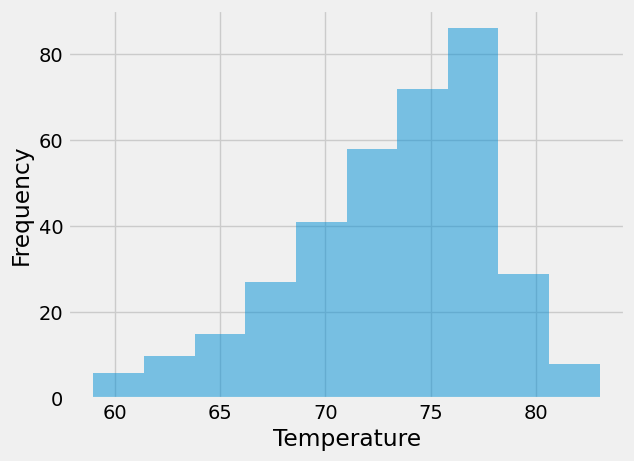

In [67]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.figure
plt.hist(MAS_id_df, alpha = 0.5)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [64]:
# Close Session
session.close()